
<font size = '20'>FOR ONE TIFF FILE</font>


/var/folders/39/0c19qs6j0k3gkl1c71w87ghr0000gn/T/ipykernel_83069/1454470864.py:36: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


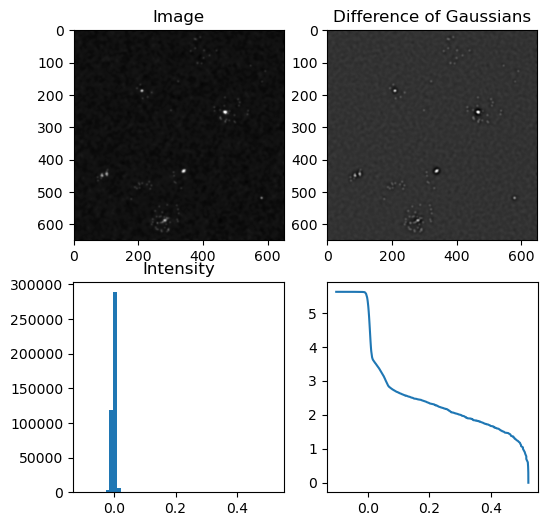

intensity range:  -0.10279021191003723 0.5222816896072586


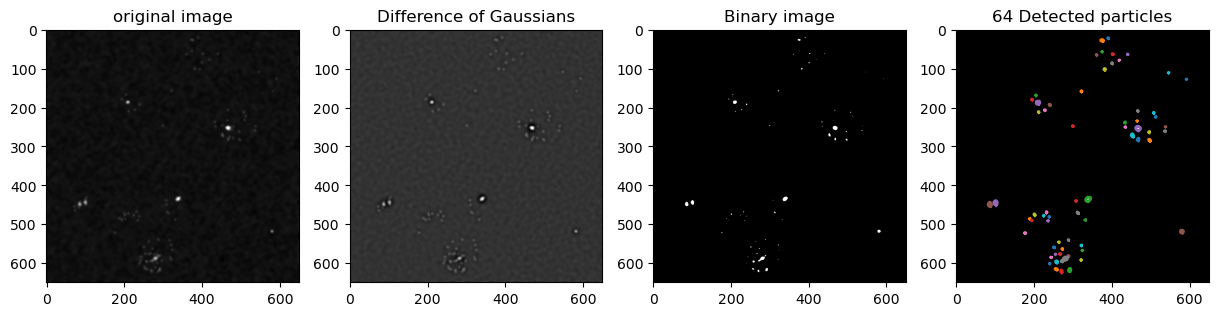

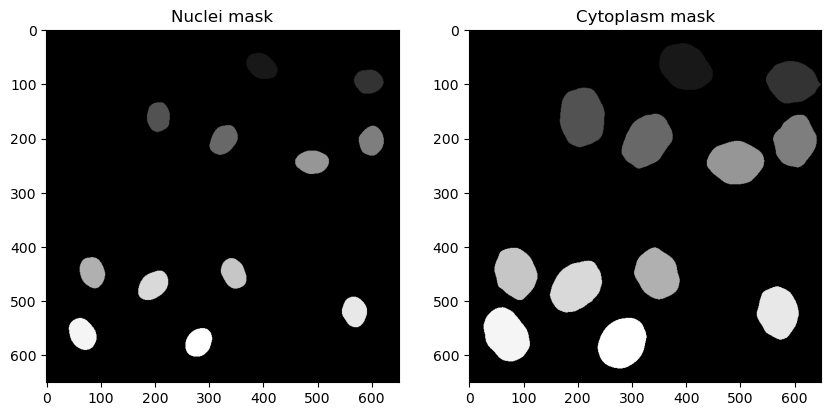

Frame 0:
    Cell ID  mRNA in cytoplasm  mRNA in nucleus  Frame
0         1                  7                4      0
1         2                  1                0      0
2         3                  6                3      0
3         4                  1                0      0
4         5                  0                0      0
5         6                  8                3      0
6         7                  3                2      0
7         8                  2                1      0
8         9                  6                3      0
9        10                  1                1      0
10       11                  0                0      0
11       12                 15                4      0
Frame 1:
    Cell ID  mRNA in cytoplasm  mRNA in nucleus  Frame
0         1                  4                2      1
1         2                  2                1      1
2         3                  7                3      1
3         4                  1                0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import difference_of_gaussians
from skimage.measure import label, regionprops
from skimage import measure

# Importing the image as variable img
figName = 'Drug1_1000nM/rep1_FOV1.tif'
img = imread(figName)
type(img)

# Selecting the color channel with RNA spots
zSlice = 0
iChannel = 2
img_spots = img[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

threshold = 0.06

# Show original image in MS2 channel 
fig, ax = plt.subplots(1,4, figsize=(15, 6)) 
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Iterate over the frames of the image
for i in range(0, img.shape[0]):
    # Select the current frame's image
    img_spots = img[i,:,:,iChannel]

    # Apply a difference of Gaussians filter to the image to enhance spots
    img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
    ax[1].imshow(img_spots_filtered,cmap='Greys_r')
    ax[1].set(title= 'Difference of Gaussians' )

    # Apply a Threshold to the image to create binary image
    img_spots_binary = img_spots_filtered.copy()
    img_spots_binary[img_spots_binary >= threshold] = threshold # Making spots above the threshold equal to the threshold value.
    img_spots_binary[img_spots_binary < threshold] = 0 # Making spots below the threshold equal to 0.
    ax[2].imshow(img_spots_binary,cmap='Greys_r')
    ax[2].set(title= 'Binary image' )

    # Image binarization
    img_spots_binary[img_spots_binary != 0] = 1 # Binarization
    ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

    # Labeling. Joining pixels in "particles"
    spot_contours = measure.find_contours(img_spots_binary, 0.5)
    for contour in spot_contours:
        ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[3].set(title= str(len(spot_contours)) + ' Detected particles' )
    plt.show()

# Import the masks
figName = 'Drug1_1000nM_masks/rep1_FOV1_mask.tif'
img_masks = imread(figName)

# Separate the channels of the mask tiff
nuc_mask = img_masks[:,:,0]  # nuclei mask
cyto_mask = img_masks[:,:,1]  # cytoplasm mask

# Plot the masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(nuc_mask, cmap='Greys_r')
ax[0].set(title='Nuclei mask')
ax[1].imshow(cyto_mask, cmap='Greys_r')
ax[1].set(title='Cytoplasm mask')
plt.show()

# Label each unique cell in the nucleus and cytoplasm masks
labeled_nuc_mask = label(nuc_mask)
labeled_cyto_mask = label(cyto_mask)

# Initialize a DataFrame to hold the counts
df_counts = pd.DataFrame(columns=['Cell ID', 'mRNA in cytoplasm', 'mRNA in nucleus'])

# Iterate over the frames of the image
for i in range(img.shape[0]):
    # Update img_spots for each frame
    img_spots = img[i,:,:,iChannel]
    img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
    img_spots_binary = img_spots_filtered.copy()
    img_spots_binary[img_spots_binary >= threshold] = threshold
    img_spots_binary[img_spots_binary < threshold] = 0
    img_spots_binary[img_spots_binary != 0] = 1
    
    # Labeling particles for the current frame
    spot_contours = measure.find_contours(img_spots_binary, 0.5)
    
    # Initialize a list to hold the data for the current frame
    data = []
    # Iterate over each unique cell in the nucleus mask
    for region in regionprops(labeled_nuc_mask):
        cell_id = region.label
        nuc_count = 0
        cyto_count = 0
        
        # Iterate over each mRNA spot
        for spot in spot_contours:
            spot_centroid = np.mean(spot, axis=0)
            y, x = int(spot_centroid[0]), int(spot_centroid[1])
            
            # Check if the spot is inside this nucleus
            if labeled_nuc_mask[y, x] == cell_id:
                nuc_count += 1
            
            # Check if the spot is inside the corresponding cytoplasm
            if labeled_cyto_mask[y, x] == cell_id:
                cyto_count += 1
        
        # Append the counts for the current cell to the list
        data.append({'Cell ID': cell_id, 'mRNA in cytoplasm': cyto_count, 'mRNA in nucleus': nuc_count, 'Frame':i})
    
    # Create a DataFrame from the list for the current frame
    df_counts_frame = pd.DataFrame(data)
    print(f"Frame {i}:")
    print(df_counts_frame)

    # Concatenate the counts for this frame to the main DataFrame
    df_counts = pd.concat([df_counts, df_counts_frame], ignore_index=True)

# Print the final DataFrame to see all results
print("Final DataFrame:")
print(df_counts)

# Save the DataFrame to a CSV file
df_counts.to_csv('mRNA_counts_tif1.csv', index=False)


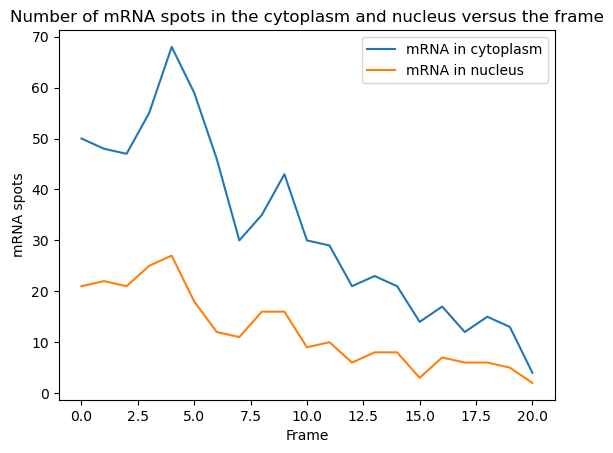

In [3]:
#I want to plot the number of mRNA spots in the cytoplasm versus the frame
# Select the data for the cytoplasm
# Assuming df_counts has a 'Frame' column

# For mRNA in cytoplasm
# Select the data for the cytoplasm

df_cyto = df_counts[['Frame', 'mRNA in cytoplasm']]
# Group the data by frame
df_cyto_grouped = df_cyto.groupby('Frame').sum()

# For mRNA in nucleus
# Select the data for the nucleus
df_nuc = df_counts[['Frame', 'mRNA in nucleus']]
# Group the data by frame
df_nuc_grouped = df_nuc.groupby('Frame').sum()

# Plotting both in the same plot
plt.plot(df_cyto_grouped, label='mRNA in cytoplasm')
plt.plot(df_nuc_grouped, label='mRNA in nucleus')
plt.xlabel('Frame')
plt.ylabel('mRNA spots')
plt.title('Number of mRNA spots in the cytoplasm and nucleus versus the frame')
plt.legend()
plt.show()


<font size = '20'>FOR A FOLDER OF TIFF FILES</font>


In [4]:
#Drug1 


import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.filters import difference_of_gaussians
from skimage.measure import label, regionprops, find_contours
from skimage import measure

# Define the folder path for images and masks
image_folder = 'Drug1_1000nM/' #change this to the folder where the images are stored
mask_folder = 'Drug1_1000nM_masks/' #change this to the folder where the masks are stored

# List all TIFF files in the image folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Initialize the DataFrame
df_counts = pd.DataFrame(columns=['Cell ID', 'mRNA in cytoplasm', 'mRNA in nucleus', 'Frame', 'Image'])

# Parameters
zSlice = 0
iChannel = 2  # Assuming the channel with RNA spots is the same for all images
threshold = 0.06

# Process each image
for image_file in image_files:
    # Read the image
    img_path = os.path.join(image_folder, image_file)
    img = imread(img_path)
    
    # Assuming a naming convention to find the corresponding mask
    mask_file = image_file.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_file)
    img_masks = imread(mask_path)
    
    # Separate the channels of the mask
    nuc_mask = img_masks[:,:,0]  # nuclei mask
    cyto_mask = img_masks[:,:,1]  # cytoplasm mask
    
    # Label each unique cell in the nucleus and cytoplasm masks
    labeled_nuc_mask = label(nuc_mask)
    labeled_cyto_mask = label(cyto_mask)
    
    # Process each frame of the image
    for i in range(img.shape[0]):
        img_spots = img[i,:,:,iChannel]
        img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
        img_spots_binary = img_spots_filtered.copy()
        img_spots_binary[img_spots_binary >= threshold] = threshold
        img_spots_binary[img_spots_binary < threshold] = 0
        img_spots_binary[img_spots_binary != 0] = 1
        
        spot_contours = find_contours(img_spots_binary, 0.5)
        
        data = []
        for region in regionprops(labeled_nuc_mask):
            cell_id = region.label
            nuc_count = 0
            cyto_count = 0
            
            for spot in spot_contours:
                spot_centroid = np.mean(spot, axis=0)
                y, x = int(spot_centroid[0]), int(spot_centroid[1])
                
                if labeled_nuc_mask[y, x] == cell_id:
                    nuc_count += 1
                
                if labeled_cyto_mask[y, x] == cell_id:
                    cyto_count += 1
            
            data.append({'Cell ID': cell_id, 'mRNA in cytoplasm': cyto_count, 'mRNA in nucleus': nuc_count, 'Frame': i, 'Image': image_file})
        
        df_counts_frame = pd.DataFrame(data)
        df_counts = pd.concat([df_counts, df_counts_frame], ignore_index=True)

# Print or save the final DataFrame
print("Final DataFrame:")
print(df_counts)

# Save the DataFrame to a CSV file
df_counts.to_csv('mRNA_counts_Drug1.csv', index=False) #change the name of the CSV file as needed



Final DataFrame:
     Cell ID mRNA in cytoplasm mRNA in nucleus Frame          Image
0          1                 7               4     0  rep1_FOV1.tif
1          2                 1               0     0  rep1_FOV1.tif
2          3                 6               3     0  rep1_FOV1.tif
3          4                 1               0     0  rep1_FOV1.tif
4          5                 0               0     0  rep1_FOV1.tif
...      ...               ...             ...   ...            ...
2725       3                 0               0    20  rep2_FOV1.tif
2726       4                 0               0    20  rep2_FOV1.tif
2727       5                 7               2    20  rep2_FOV1.tif
2728       6                 0               0    20  rep2_FOV1.tif
2729       7                 0               0    20  rep2_FOV1.tif

[2730 rows x 5 columns]


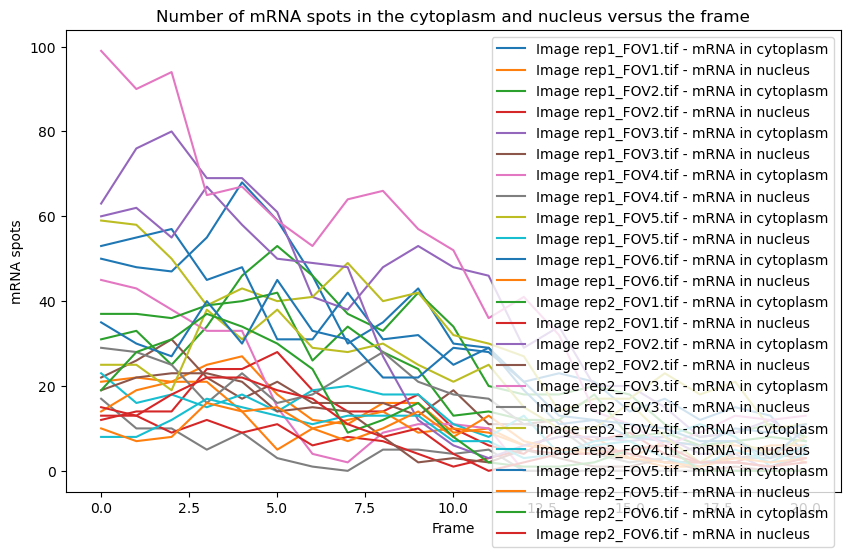

In [5]:
df = pd.read_csv('mRNA_counts_Drug1.csv')

# Group the data by 'Image'
df_grouped = df.groupby('Image')

# Plotting
plt.figure(figsize=(10, 6))

for video in df_grouped.groups.keys():
    vid_df = df_grouped.get_group(video)
    # Select the data for the cytoplasm
    df_cyto = vid_df[['Frame', 'mRNA in cytoplasm']]
    # Group the data by frame
    df_cyto_grouped = df_cyto.groupby('Frame').sum()

    # Select the data for the nucleus
    df_nuc = vid_df[['Frame', 'mRNA in nucleus']]
    # Group the data by frame
    df_nuc_grouped = df_nuc.groupby('Frame').sum()

    # Plotting both in the same plot
    plt.plot(df_cyto_grouped, label=f'Image {video} - mRNA in cytoplasm')
    plt.plot(df_nuc_grouped, label=f'Image {video} - mRNA in nucleus')

plt.xlabel('Frame')
plt.ylabel('mRNA spots')
plt.title('Number of mRNA spots in the cytoplasm and nucleus versus the frame')
plt.legend()
plt.show()

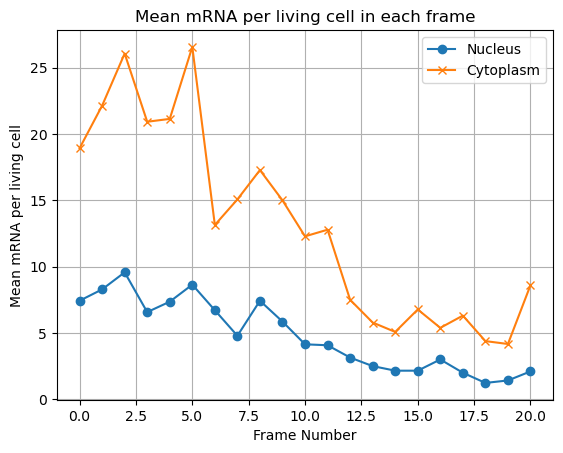

In [13]:
#Drug 1 1000nM
#Where is defined what csv file to read from?
#Read the CSV file with the information of living cells and mRNA spots
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file with the information of living cells and mRNA spots
df_counts = pd.read_csv('Drug1_metadata.csv')

# Filter the data to include only living cells
df_living_cells = df_counts[df_counts['Alive'] == 1]

# Group the filtered data by 'Frame'
df_grouped = df_living_cells.groupby('time')

# Initialize lists to hold the mean values for nucleus and cytoplasm
mean_nuc_mRNA = []
mean_cyto_mRNA = []

# Iterate over each frame
for frame, group in df_grouped:
    # Calculate the mean of nuclear mRNA per living cell
    mean_mRNA_nuc = group['number_of_mRNA_in_nucleus'].sum() / len(group['cell_number'].unique())
    mean_nuc_mRNA.append(mean_mRNA_nuc)
    
    # Calculate the mean of cytoplasmic mRNA per living cell
    mean_mRNA_cyto = group['number_of_mRNA_in_cytoplasm'].sum() / len(group['cell_number'].unique())  # Assuming a column for cytoplasmic mRNA
    mean_cyto_mRNA.append(mean_mRNA_cyto)

# Plot the mean nuclear and cytoplasmic mRNA per living cell in each frame
plt.plot(list(df_grouped.groups.keys()), mean_nuc_mRNA, marker='o', label='Nucleus')  # Nucleus
plt.plot(list(df_grouped.groups.keys()), mean_cyto_mRNA, marker='x', label='Cytoplasm')  # Cytoplasm
plt.xlabel('Frame Number')
plt.ylabel('Mean mRNA per living cell')
plt.title('Mean mRNA per living cell in each frame')
plt.grid(True)
plt.legend()
plt.show()


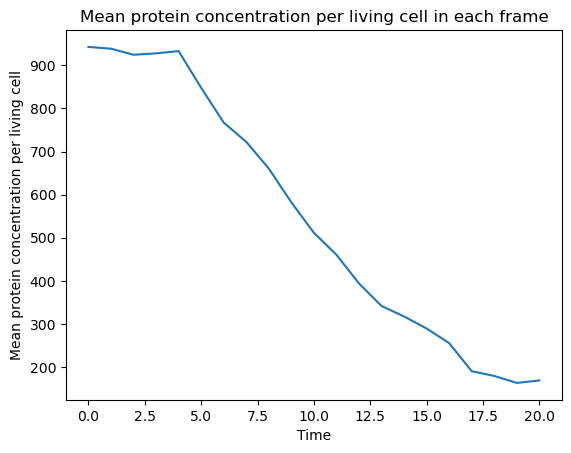

In [11]:
#Drug 1 1000nM
#Where is defined what csv file to read from?
#Read the CSV file with the information of living cells and mRNA spots
df_counts = pd.read_csv('Drug1_metadata.csv')

#calculate the mean of nuclear mRNA per living cell in each frame
# Group the data by 'Frame'
df_grouped = df_counts.groupby('time')

# Initialize a list to hold the mean values
mean_protein_concentration = []

# Iterate over each frame
for frame, group in df_grouped:
    # select only the living cells to plot, using the 'Alive' column as a filter
    group = group[group['Alive'] == 1]
    # Calculate the mean of nuclear mRNA per living cell
    mean_protein = group['protein_concentration'].sum() / len(group['cell_number'].unique())
    mean_protein_concentration.append(mean_protein)

# Plot the mean nuclear mRNA per living cell in each frame
plt.plot(df_grouped.groups.keys(), mean_protein_concentration)
plt.xlabel('Time')
plt.ylabel('Mean protein concentration per living cell')
plt.title('Mean protein concentration per living cell in each frame')
plt.show()

In [ ]:
#Drug 4


import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.filters import difference_of_gaussians
from skimage.measure import label, regionprops, find_contours
from skimage import measure

# Define the folder path for images and masks
image_folder = 'Drug4_1000nM/'
mask_folder = 'Drug4_1000nM_masks/'

# List all TIFF files in the image folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Initialize the DataFrame
df_counts = pd.DataFrame(columns=['Cell ID', 'mRNA in cytoplasm', 'mRNA in nucleus', 'Frame', 'Image'])

# Parameters
zSlice = 0
iChannel = 2  # Assuming the channel with RNA spots is the same for all images
threshold = 0.06

# Process each image
for image_file in image_files:
    # Read the image
    img_path = os.path.join(image_folder, image_file)
    img = imread(img_path)
    
    # Assuming a naming convention to find the corresponding mask
    mask_file = image_file.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_file)
    img_masks = imread(mask_path)
    
    # Separate the channels of the mask
    nuc_mask = img_masks[:,:,0]  # nuclei mask
    cyto_mask = img_masks[:,:,1]  # cytoplasm mask
    
    # Label each unique cell in the nucleus and cytoplasm masks
    labeled_nuc_mask = label(nuc_mask)
    labeled_cyto_mask = label(cyto_mask)
    
    # Process each frame of the image
    for i in range(img.shape[0]):
        img_spots = img[i,:,:,iChannel]
        img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
        img_spots_binary = img_spots_filtered.copy()
        img_spots_binary[img_spots_binary >= threshold] = threshold
        img_spots_binary[img_spots_binary < threshold] = 0
        img_spots_binary[img_spots_binary != 0] = 1
        
        spot_contours = find_contours(img_spots_binary, 0.5)
        
        data = []
        for region in regionprops(labeled_nuc_mask):
            cell_id = region.label
            nuc_count = 0
            cyto_count = 0
            
            for spot in spot_contours:
                spot_centroid = np.mean(spot, axis=0)
                y, x = int(spot_centroid[0]), int(spot_centroid[1])
                
                if labeled_nuc_mask[y, x] == cell_id:
                    nuc_count += 1
                
                if labeled_cyto_mask[y, x] == cell_id:
                    cyto_count += 1
            
            data.append({'Cell ID': cell_id, 'mRNA in cytoplasm': cyto_count, 'mRNA in nucleus': nuc_count, 'Frame': i, 'Image': image_file})
        
        df_counts_frame = pd.DataFrame(data)
        df_counts = pd.concat([df_counts, df_counts_frame], ignore_index=True)

# Print or save the final DataFrame
print("Final DataFrame:")
print(df_counts)

# Save the DataFrame to a CSV file
df_counts.to_csv('mRNA_counts_Drug4.csv', index=False)



Final DataFrame:
     Cell ID mRNA in cytoplasm mRNA in nucleus Frame          Image
0          1                 9               2     0  rep1_FOV1.tif
1          2                 2               2     0  rep1_FOV1.tif
2          3                 5               0     0  rep1_FOV1.tif
3          4                 5               3     0  rep1_FOV1.tif
4          5                 1               1     0  rep1_FOV1.tif
...      ...               ...             ...   ...            ...
2641      10                 9               0    20  rep2_FOV1.tif
2642      11                 0               3    20  rep2_FOV1.tif
2643      12                10               0    20  rep2_FOV1.tif
2644      13                 7               3    20  rep2_FOV1.tif
2645      14                 0               5    20  rep2_FOV1.tif

[2646 rows x 5 columns]


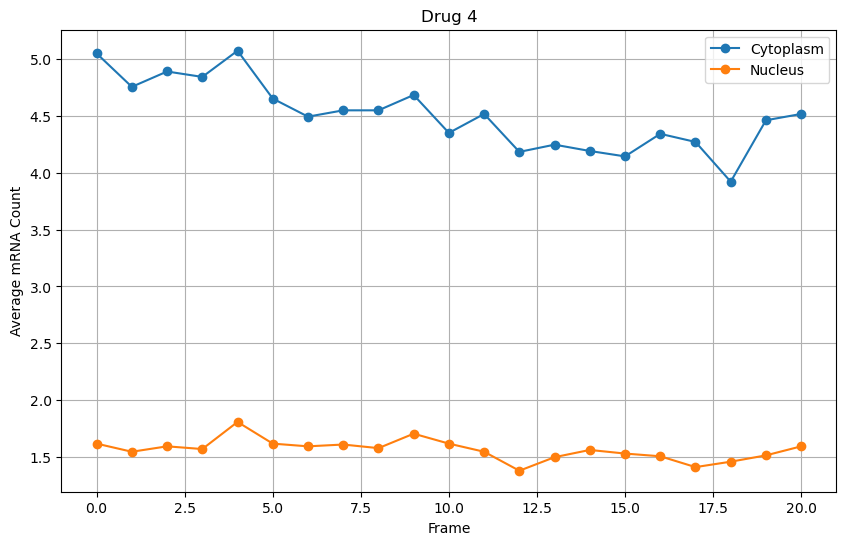

In [ ]:
#Drug 4 1000nM

# Read the CSV file
df_counts = pd.read_csv('mRNA_counts_Drug4.csv')
# Group by 'Frame' and calculate the mean of 'mRNA in cytoplasm' and 'mRNA in nucleus' for each frame
average_mRNA_cytoplasm = df_counts.groupby('Frame')['mRNA in cytoplasm'].mean()
average_mRNA_nucleus = df_counts.groupby('Frame')['mRNA in nucleus'].mean()

# Plot the average mRNA count in the cytoplasm and nucleus for each frame
plt.figure(figsize=(10, 6))
plt.plot(average_mRNA_cytoplasm.index, average_mRNA_cytoplasm.values, marker='o', linestyle='-', label='Cytoplasm')
plt.plot(average_mRNA_nucleus.index, average_mRNA_nucleus.values, marker='o', linestyle='-', label='Nucleus')
plt.title('Drug 4')
plt.xlabel('Frame')
plt.ylabel('Average mRNA Count')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Drug 10


import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.filters import difference_of_gaussians
from skimage.measure import label, regionprops, find_contours
from skimage import measure

# Define the folder path for images and masks
image_folder = 'Drug10_1000nM/'
mask_folder = 'Drug10_1000nM_masks/'

# List all TIFF files in the image folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Initialize the DataFrame
df_counts = pd.DataFrame(columns=['Cell ID', 'mRNA in cytoplasm', 'mRNA in nucleus', 'Frame', 'Image'])

# Parameters
zSlice = 0
iChannel = 2  # Assuming the channel with RNA spots is the same for all images
threshold = 0.06

# Process each image
for image_file in image_files:
    # Read the image
    img_path = os.path.join(image_folder, image_file)
    img = imread(img_path)
    
    # Assuming a naming convention to find the corresponding mask
    mask_file = image_file.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_folder, mask_file)
    img_masks = imread(mask_path)
    
    # Separate the channels of the mask
    nuc_mask = img_masks[:,:,0]  # nuclei mask
    cyto_mask = img_masks[:,:,1]  # cytoplasm mask
    
    # Label each unique cell in the nucleus and cytoplasm masks
    labeled_nuc_mask = label(nuc_mask)
    labeled_cyto_mask = label(cyto_mask)
    
    # Process each frame of the image
    for i in range(img.shape[0]):
        img_spots = img[i,:,:,iChannel]
        img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
        img_spots_binary = img_spots_filtered.copy()
        img_spots_binary[img_spots_binary >= threshold] = threshold
        img_spots_binary[img_spots_binary < threshold] = 0
        img_spots_binary[img_spots_binary != 0] = 1
        
        spot_contours = find_contours(img_spots_binary, 0.5)
        
        data = []
        for region in regionprops(labeled_nuc_mask):
            cell_id = region.label
            nuc_count = 0
            cyto_count = 0
            
            for spot in spot_contours:
                spot_centroid = np.mean(spot, axis=0)
                y, x = int(spot_centroid[0]), int(spot_centroid[1])
                
                if labeled_nuc_mask[y, x] == cell_id:
                    nuc_count += 1
                
                if labeled_cyto_mask[y, x] == cell_id:
                    cyto_count += 1
            
            data.append({'Cell ID': cell_id, 'mRNA in cytoplasm': cyto_count, 'mRNA in nucleus': nuc_count, 'Frame': i, 'Image': image_file})
        
        df_counts_frame = pd.DataFrame(data)
        df_counts = pd.concat([df_counts, df_counts_frame], ignore_index=True)

# Print or save the final DataFrame
print("Final DataFrame:")
print(df_counts)

# Save the DataFrame to a CSV file
df_counts.to_csv('mRNA_counts_Drug10.csv', index=False)



Final DataFrame:
     Cell ID mRNA in cytoplasm mRNA in nucleus Frame          Image
0          1                 5               2     0  rep1_FOV1.tif
1          2                 8               2     0  rep1_FOV1.tif
2          3                 0               0     0  rep1_FOV1.tif
3          4                 1               1     0  rep1_FOV1.tif
4          5                 7               2     0  rep1_FOV1.tif
...      ...               ...             ...   ...            ...
2557       6                 0               0    20  rep2_FOV1.tif
2558       7                 0               0    20  rep2_FOV1.tif
2559       8                 4               0    20  rep2_FOV1.tif
2560       9                 0               0    20  rep2_FOV1.tif
2561      10                 0               1    20  rep2_FOV1.tif

[2562 rows x 5 columns]


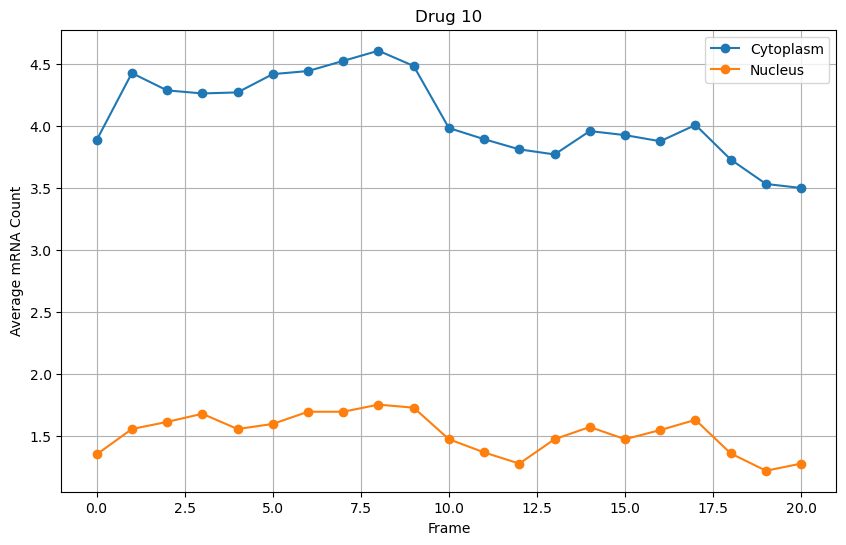

In [ ]:
#Drug 10 1000nM

# Read the CSV file
df_counts = pd.read_csv('mRNA_counts_Drug10.csv')
# Group by 'Frame' and calculate the mean of 'mRNA in cytoplasm' and 'mRNA in nucleus' for each frame
average_mRNA_cytoplasm = df_counts.groupby('Frame')['mRNA in cytoplasm'].mean()
average_mRNA_nucleus = df_counts.groupby('Frame')['mRNA in nucleus'].mean()

# Plot the average mRNA count in the cytoplasm and nucleus for each frame
plt.figure(figsize=(10, 6))
plt.plot(average_mRNA_cytoplasm.index, average_mRNA_cytoplasm.values, marker='o', linestyle='-', label='Cytoplasm')
plt.plot(average_mRNA_nucleus.index, average_mRNA_nucleus.values, marker='o', linestyle='-', label='Nucleus')
plt.title('Drug 10')
plt.xlabel('Frame')
plt.ylabel('Average mRNA Count')
plt.legend()
plt.grid(True)
plt.show()


<font size = 20>PLOTS FROM METADATA for tiff 1</font>


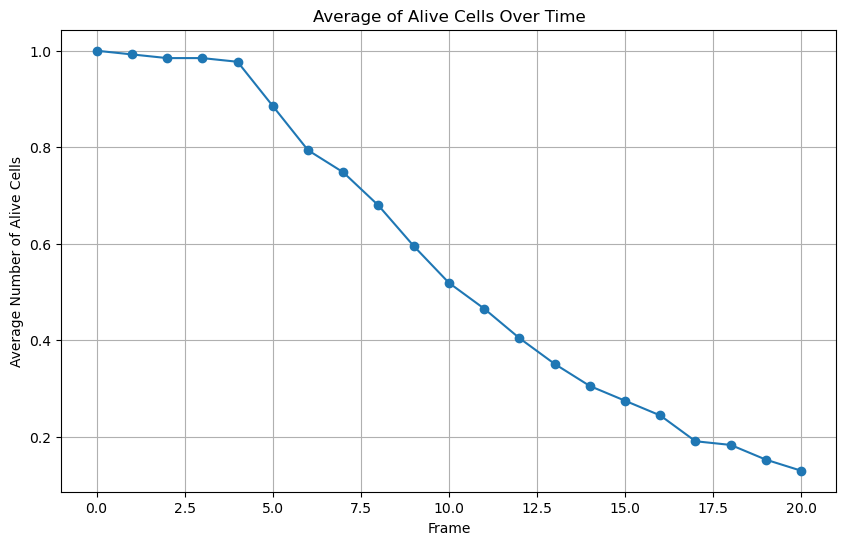

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata from CSV file into a DataFrame
metadata_df = pd.read_csv('Drug1_metadata.csv')

# Group by 'time' (frame) and calculate the mean of 'Alive' for each frame
average_alive_cells = metadata_df.groupby('time')['Alive'].mean()

# Plot the average of alive cells over time
plt.figure(figsize=(10, 6))
plt.plot(average_alive_cells.index, average_alive_cells.values, marker='o', linestyle='-')
plt.title('Average of Alive Cells Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Number of Alive Cells')
plt.grid(True)
plt.show()


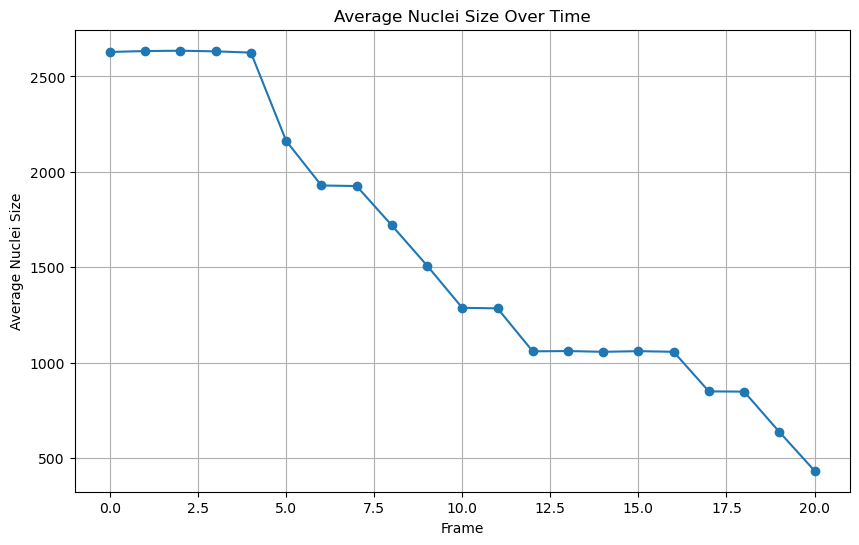

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata from CSV file into a DataFrame
metadata_df = pd.read_csv('metadata.csv')

# Group by 'time' (frame) and calculate the mean of 'nuclei_size' for each frame
average_nuclei_size = metadata_df.groupby('time')['nuclei_size'].mean()

# Plot the average nuclei size over time
plt.figure(figsize=(10, 6))
plt.plot(average_nuclei_size.index, average_nuclei_size.values, marker='o', linestyle='-')
plt.title('Average Nuclei Size Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Nuclei Size')
plt.grid(True)
plt.show()


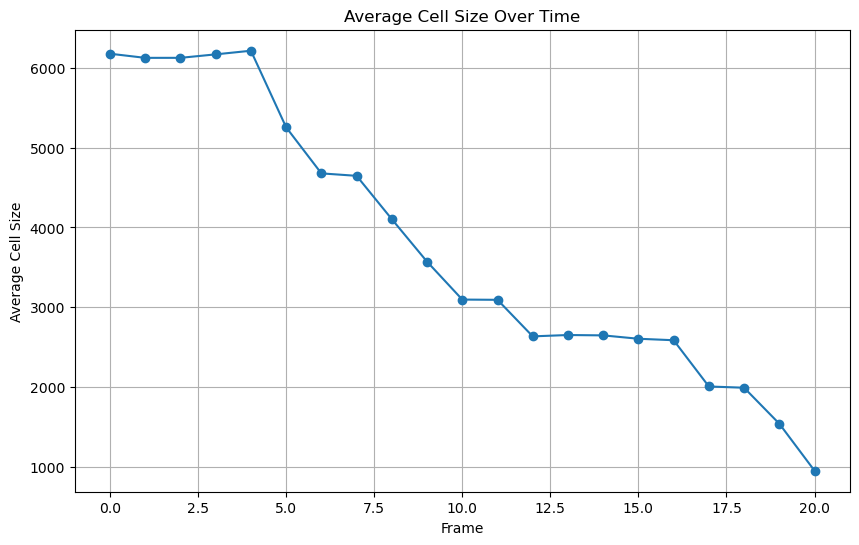

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata from CSV file into a DataFrame
metadata_df = pd.read_csv('metadata.csv')

# Group by 'time' (frame) and calculate the mean of 'cell_size' for each frame
average_cell_size = metadata_df.groupby('time')['cell_size'].mean()

# Plot the average cell size over time
plt.figure(figsize=(10, 6))
plt.plot(average_cell_size.index, average_cell_size.values, marker='o', linestyle='-')
plt.title('Average Cell Size Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Cell Size')
plt.grid(True)
plt.show()


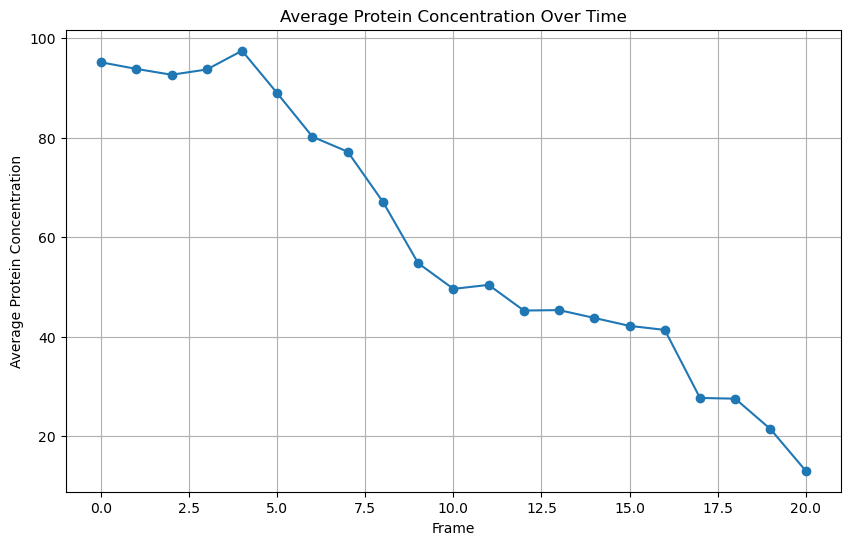

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata from CSV file into a DataFrame
metadata_df = pd.read_csv('metadata.csv')

# Group by 'time' (frame) and calculate the mean of 'protein_concentration' for each frame
average_protein_concentration = metadata_df.groupby('time')['protein_concentration'].mean()

# Plot the average protein concentration over time
plt.figure(figsize=(10, 6))
plt.plot(average_protein_concentration.index, average_protein_concentration.values, marker='o', linestyle='-')
plt.title('Average Protein Concentration Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Protein Concentration')
plt.grid(True)
plt.show()
